In [ ]:
! pip install fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [178]:
! pip install geopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import libraries

In [179]:
from fastai.vision.all import *
import pandas as pd
from geopy.geocoders import Nominatim
import numpy as np

In [3]:
#mount the google drive in order to get the Grozi-3.2K dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/Code Challenges/hackathon'

images_train = path + '/train_test_data/train'
labels_train = path + '/train.csv'

images_test = path + '/train_test_data/test'
labels_test = path + '/test.csv'

In [5]:
train_df = pd.read_csv(labels_train)
test_df = pd.read_csv(labels_test)
train_df.head()

,label,latitude,longitude,year,example_path
0,0,-2.051853,111.826093,2001,train_test_data/train/1297.png
1,2,-1.989349,105.309496,2013,train_test_data/train/1199.png
2,0,1.223256,100.702217,2014,train_test_data/train/1348.png
3,0,-2.342948,103.890226,2008,train_test_data/train/2214.png
4,0,-0.126555,101.758175,2011,train_test_data/train/2220.png


In [6]:
#extract name of the image and create a new column with the name and without the extension
train_df['name'] = train_df['example_path'].apply(lambda x: x.split('/')[-1])
train_df['name'] = train_df['name'].str.split('.').str[0]

In [7]:
test_df['name'] = test_df['example_path'].apply(lambda x: x.split('/')[-1])
test_df['name'] = test_df['name'].str.split('.').str[0]

In [8]:
#change format of the labels to string
train_df['label'] = train_df['label'].astype(str)

In [177]:
#data exploration on the train dataset

labels = {"0": 'Plantation', "1": 'Grassland/Shrubland' , "2": 'Smallholder Agriculture'}

train_df['label_name'] = train_df['label'].map(labels)

train_df['label_name'].value_counts()

Plantation                 860
Smallholder Agriculture    658
Grassland/Shrubland        196
Name: label_name, dtype: int64

Get the location of the coordinates

In [180]:
# initialize Nominatim API
geolocator = Nominatim(user_agent="geoapiExercises")

lat_1 = train_df['latitude'][0]
long_1 = train_df['longitude'][0]

location = geolocator.reverse(str(lat_1) + ', ' + str(long_1))
print(location)

Kalimantan Tengah, Indonesia


In [181]:
#function to get the country name from the latitude and longitude
def get_location(lat, long):
    location = geolocator.reverse(str(lat) + ', ' + str(long))
    return location[0]

In [182]:
train_df['location'] = train_df.apply(lambda x: get_location(x['latitude'], x['longitude']), axis=1)

In [183]:
#save in new columns the country and the state
train_df['country'] = train_df['location'].apply(lambda x: x.split(',')[-1])
train_df['state'] = train_df['location'].apply(lambda x: x.split(',')[-2])

In [184]:
print(train_df.country.value_counts())

 Indonesia    1714
Name: country, dtype: int64


## Evolution of the labels over time

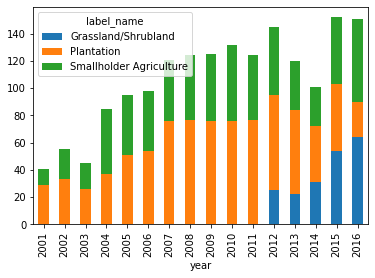

In [185]:
#plot the evolution of the labels over time
train_df.groupby(['year', 'label_name']).size().unstack().plot(kind='bar', stacked=True)

## Preprocessing

In [9]:
def get_data(size=224,bs=64,data_df=train_df):
    dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                       splitter=RandomSplitter(seed=42),
                       get_x=ColReader(5, pref=f'{path}/train_test_data/train/' , suff='.png'),
                       get_y=ColReader(0 , label_delim=' '),
                       item_tfms = Resize(size),
                       batch_tfms = [*aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.),
                                     Normalize.from_stats(*imagenet_stats)]
                      )
    return dblock.dataloaders(data_df,bs=bs)

In [10]:
dls = get_data(128,256)

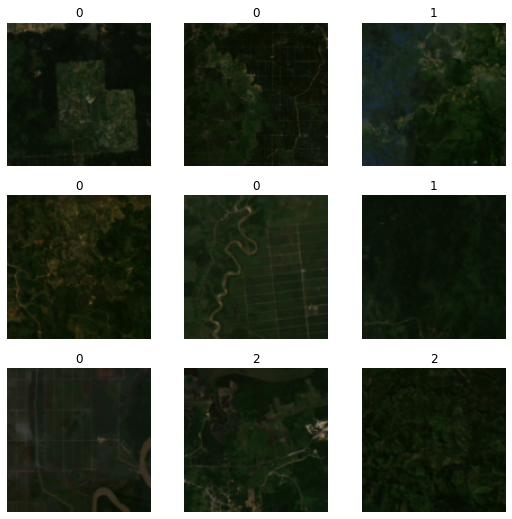

In [11]:
dls.show_batch()

## Setting metrics for analyzing performance of the model

In [12]:
metrics = [partial(accuracy_multi, thresh=0.2), FBetaMulti(beta=1 #f1 score
                                                           , average='samples',
                                                           thresh=0.2)]
cbs = [MixUp]

## Selection of ResNet 50 as the model

The model is defined and the next step is using fastai method to find the suggested learning rate

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0006918309954926372)

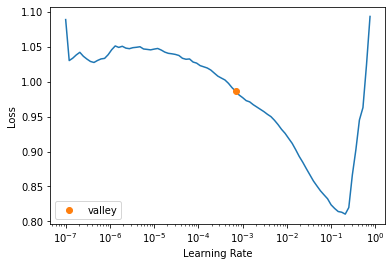

In [13]:
learn = cnn_learner(dls, resnet50, metrics=metrics, cbs=cbs).to_fp16()
learn.lr_find()

## Training

In [14]:
learn.fine_tune(6, base_lr=2e-2, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.985268,0.695193,0.524366,0.577973,02:30
1,0.955263,0.846837,0.525341,0.586745,00:15
2,0.868922,0.572422,0.642300,0.634503,00:15
3,0.784000,0.502100,0.721248,0.701267,00:15


epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.498276,0.487703,0.705653,0.689084,00:14
1,0.484437,1.334277,0.730994,0.620858,00:15
2,0.468847,3.015816,0.727095,0.597466,00:14
3,0.450914,1.241083,0.761209,0.687622,00:13
4,0.433108,0.675255,0.782651,0.729045,00:15
5,0.418669,0.521428,0.801170,0.750000,00:14


In [15]:
learn.save('resnet50-128')

Path('models/resnet50-128.pth')

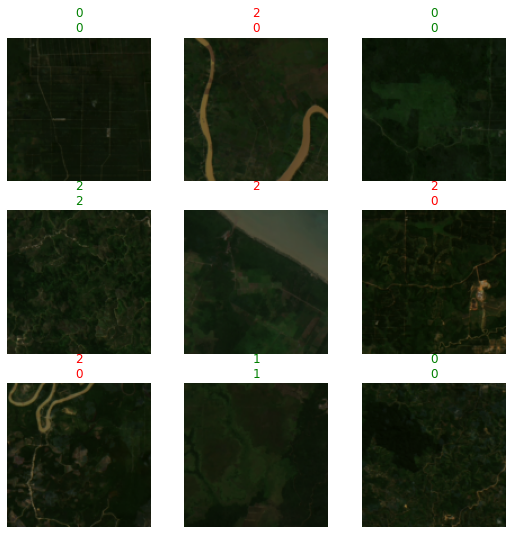

In [16]:
learn.show_results()

In [17]:
learn.export()

## Predictions on the test dataset

In [21]:
test_df.head()

,latitude,longitude,year,example_path,name
0,0.761681,122.755954,2006,train_test_data/test/69.png,69
1,-8.059785,113.053791,2007,train_test_data/test/469.png,469
2,-2.006610,111.746316,2002,train_test_data/test/6.png,6
3,0.901765,114.042495,2016,train_test_data/test/351.png,351
4,1.911210,100.829633,2008,train_test_data/test/1001.png,1001
...,...,...,...,...,...
630,1.650899,101.314723,2011,train_test_data/test/968.png,968
631,-1.645649,102.612332,2010,train_test_data/test/54.png,54
632,-0.557796,114.561609,2016,train_test_data/test/494.png,494
633,-3.037549,113.872045,2009,train_test_data/test/287.png,287


In [25]:
test_df['complete_path'] = images_test + '/' + test_df.name + '.png'

## Exporting predictions to submission file

In [164]:
def prediction(filename):
    tst_dl = learn.dls.test_dl(test_df['complete_path'])
  
    predictions = learn.get_preds(dl = tst_dl)

    pred_array = np.array(predictions[0])

    predlist = [np.argmax(i) for i in pred_array]

    df = test_df
    df['target'] = predlist

    df.to_csv(filename, index=False)
    return df

In [165]:
prediction('submission.csv')

,latitude,longitude,year,example_path,name,complete_path,target
0,0.761681,122.755954,2006,train_test_data/test/69.png,69,/content/drive/MyDrive/Code Challenges/hackathon/train_test_data/test/69.png,2
1,-8.059785,113.053791,2007,train_test_data/test/469.png,469,/content/drive/MyDrive/Code Challenges/hackathon/train_test_data/test/469.png,2
2,-2.006610,111.746316,2002,train_test_data/test/6.png,6,/content/drive/MyDrive/Code Challenges/hackathon/train_test_data/test/6.png,0
3,0.901765,114.042495,2016,train_test_data/test/351.png,351,/content/drive/MyDrive/Code Challenges/hackathon/train_test_data/test/351.png,2
4,1.911210,100.829633,2008,train_test_data/test/1001.png,1001,/content/drive/MyDrive/Code Challenges/hackathon/train_test_data/test/1001.png,2
...,...,...,...,...,...,...,...
630,1.650899,101.314723,2011,train_test_data/test/968.png,968,/content/drive/MyDrive/Code Challenges/hackathon/train_test_data/test/968.png,2
631,-1.645649,102.612332,2010,train_test_data/test/54.png,54,/content/drive/MyDrive/Code Challenges/hackathon/train_test_data/test/54.png,1
632,-0.557796,114.561609,2016,train_test_data/test/494.png,494,/content/drive/MyDrive/Code Challenges/hackathon/train_test_data/test/494.png,0
633,-3.037549,113.872045,2009,train_test_data/test/287.png,287,/content/drive/MyDrive/Code Challenges/hackathon/train_test_data/test/287.png,0


In [166]:
submission_df = pd.read_csv('/content/submission.csv')

In [171]:
submission_df.target.value_counts()

0    373
2    187
1     75
Name: target, dtype: int64

# Final JSON file with predictions


In [200]:
predictions_df = submission_df[['name', 'target']]
predictions_df.columns = ['target','predictions']

In [204]:
predictions_df.to_csv('predictions.csv' )

In [211]:
predictions_df.to_json('predictions.json')